In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

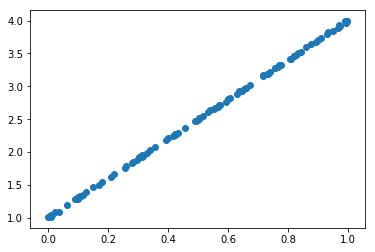

In [2]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, D_out = 100, 1, 1

def build_linear_dataset(N, p=1, noise_std=0.01):
    X = np.random.rand(N, p)
    # w = 3
    w = 3 * np.ones(p)
    # b = 1
    y = np.matmul(X, w) + np.repeat(1, N) + np.random.normal(0, noise_std, size=N)
    y = y.reshape(N, 1)
    X, y = torch.tensor(X).type(torch.Tensor), torch.tensor(y).type(torch.Tensor)
    data = torch.cat((X, y), 1)
    assert data.shape == (N, p + 1)
    return data

data = build_linear_dataset(N)
x_train = data[:, :-1]
y_train = data[:, -1]
    


plt.scatter(x_train, y_train)

x = Variable(x_train)
y = Variable(y_train)

In [3]:
softplus = torch.nn.Softplus()
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

def sample_w(mu, var):
    eps = Variable(torch.randn(*mu.size()))
    return mu + softplus(var) * eps

def sample_b(mu, var):
    eps = Variable(torch.randn(*mu.size()))
    return mu + softplus(var) * eps

def KL_diagLogـ(mean, mean_prior, logsigma, logsigma_prior):
    # https://tgmstat.wordpress.com/2013/07/10/kullback-leibler-divergence/
    mu = mean_prior.view(-1)
    mu_pr = mean.view(-1)

    logSig = logsigma.view(-1)
    logSig_prior = logsigma_prior.view(-1)

    A = logSig_prior - logSig
    B = torch.pow(mu - mu_pr, 2)  / torch.exp(logSig_prior)
    C = torch.exp(logSig - logSig_prior) - 1

    return 0.5 * torch.sum(A + B + C)

def KL_diagLog(mean, mean_prior, log_sigma, sigma_prior):
    mu = mean_prior.view(-1)
    mu_pr = mean.view(-1)

    Sig = torch.pow(softplus(log_sigma.view(-1)), 2)
    Sig_prior = torch.pow(sigma_prior.view(-1),2)
    

    A = torch.log(Sig_prior) - torch.log(Sig)
    B = torch.pow(mu - mu_pr, 2)  / Sig_prior
    C = Sig / Sig_prior - 1

    return 0.5 * torch.sum(A + B + C)

W_mu_prior =  torch.zeros(D_in, D_out)
W_var_prior = 10*torch.ones(D_in, D_out)

W_mu = xavier_init(size=[D_in, D_out]);
W_var = Variable(-3*torch.ones(D_in, D_out), requires_grad=True)
#W_var = Variable(-30*torch.ones(D_in, D_out), requires_grad=True)

#b_mu_prior = torch.tensor(torch.mean(y_train), dtype = torch.float32) #torch.zeros(D_out)
b_mu_prior = torch.zeros(D_out)
b_var_prior = 3*torch.ones(D_out)

b_mu = Variable(torch.zeros(D_out), requires_grad=True)
b_var = Variable(-3*torch.ones(D_out), requires_grad=True)
#b_var = Variable(-30*torch.ones(D_out), requires_grad=True)

def model(x):  
    W = sample_w(W_mu, W_var)
    b = sample_b(b_mu, b_var)
    out = x @ W + b.repeat(x.size(0), 1)
    return out

In [4]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Variables it should update.
learning_rate = 0.05
optimizer = torch.optim.Adam([W_mu, b_mu, W_var, b_var], lr=learning_rate)
loss_fn = torch.nn.MSELoss(size_average=False)
#loss_fn = torch.nn.NLLLoss(size_average=False)
for t in range(1000):
    mu = torch.cat((W_mu.view(-1), b_mu.view(-1)))
    mu_prior = torch.cat((W_mu_prior.view(-1), b_mu_prior.view(-1)))
    var = torch.cat((W_var.view(-1), b_var.view(-1)))
    var_prior = torch.cat((W_var_prior.view(-1), b_var_prior.view(-1)))
                   
    kl_loss = KL_diagLog(mu, mu_prior, var, var_prior)
    mc_list = [loss_fn(model(x).squeeze(-1), y) for i in range(10)]
    loss = sum(mc_list) / len(mc_list) + kl_loss

    if (t+1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (t + 1, loss.item()))
    

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

[iteration 0050] loss: 75.7576
[iteration 0100] loss: 39.6202
[iteration 0150] loss: 28.5435
[iteration 0200] loss: 20.7568
[iteration 0250] loss: 15.9748
[iteration 0300] loss: 11.8207
[iteration 0350] loss: 10.0126
[iteration 0400] loss: 9.0888
[iteration 0450] loss: 8.2385
[iteration 0500] loss: 8.2883
[iteration 0550] loss: 8.6016
[iteration 0600] loss: 8.3363
[iteration 0650] loss: 7.8713
[iteration 0700] loss: 7.8859
[iteration 0750] loss: 8.1943
[iteration 0800] loss: 7.8499
[iteration 0850] loss: 7.8832
[iteration 0900] loss: 7.8294
[iteration 0950] loss: 8.3669
[iteration 1000] loss: 9.3878


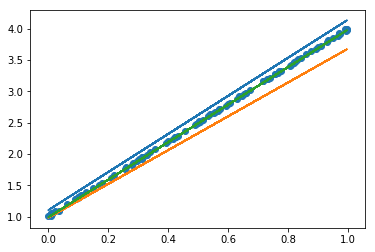

In [5]:
plt.scatter(x.data.numpy(), y.data.numpy())
y_pred1 = model(x)
y_pred2 = model(x)
y_pred3 = model(x)
plt.plot(x.data.numpy(),y_pred1.data.numpy())
plt.plot(x.data.numpy(),y_pred2.data.numpy())
plt.plot(x.data.numpy(),y_pred3.data.numpy())

In [6]:
print(2*b_var)
print(b_mu)
print(W_mu)
print(2*W_var)

tensor([-5.2586])
tensor([ 1.0051])
tensor([[ 2.9944]])
tensor([[-4.0168]])


In [12]:
mu = torch.tensor([1., 1.2])
sigma = torch.tensor([2.5, 2.2])
mu_p = torch.tensor([1.5, 1.3])
sigma_p = torch.tensor([10., 8.5])
print(KL_diagLog(mu, mu_p, sigma, sigma_p))
print(KL_diagLogـ(mu, mu_p, 2*torch.log(softplus(sigma)), 2*torch.log(sigma_p)))

tensor(1.7315)
tensor(1.7315)
